#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [1]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install salesforce-lavis
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess

/home/bearcat/anaconda3/envs/lavis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load an example image

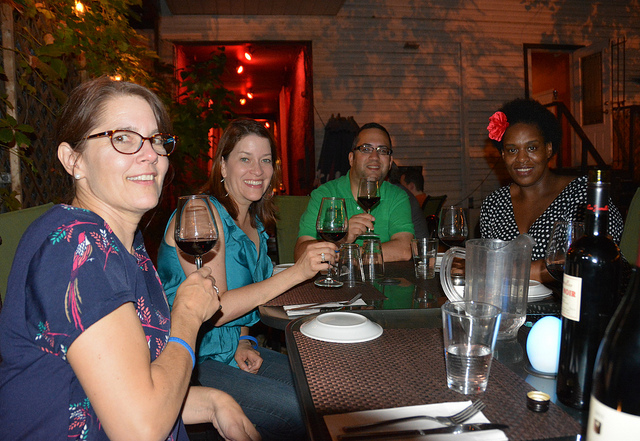

In [13]:
raw_image = Image.open("/mnt/bearcat/LocNar/coco/train2017/000000575711.jpg").convert('RGB')   
display(raw_image)

In [14]:
# setup device to use
device = "cpu"

#### Load pretrained/finetuned BLIP2 captioning model

In [5]:
# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device
)

# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

Loading checkpoint shards: 100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


dict_keys(['train', 'eval'])

#### prepare the image as model input using the associated processors

In [15]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

#### generate caption using beam search

In [16]:
model.generate({"image": image})

['a group of people sitting at a table drinking wine']

#### generate multiple captions using nucleus sampling

In [17]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

['a group of people sitting at a table drinking wine',
 'a group of people sitting at a table drinking wine',
 'a group of people sitting at a table drinking wine']

#### instructed zero-shot vision-to-language generation

In [21]:
model.generate({"image": image, "prompt": "tell a story about the image. Answer:"})

['a group of people are posing for a photo at a restaurant']

In [10]:
model.generate({
    "image": image,
    "prompt": "Question: which city is this? Answer: singapore. Question: why?"})

['it has a statue of a merlion']

In [11]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [12]:
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)

['merlion is a portmanteau of mermaid and lion']